In [2]:
# importation de quelques librairies

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np
import pickle

# importation des librairies pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from dotenv import load_dotenv
import os

load_dotenv()

True

In [3]:
# variable pour entrainer les modèles catboost et réseau de neurones

train_model = True

In [4]:
# chemin de nos données d'entrainement et de test

train_path = os.getenv('STAR_TRAIN_PATH')
test_path = os.getenv('STAR_TEST_PATH')

# chargement des données

df_train = pd.read_csv(train_path).drop('obj_ID', axis=1)
df_test = pd.read_csv(test_path)

## Analyse des données

In [5]:
# visualisation des données

df_train.head()

,alpha,delta,u,g,r,i,z,redshift,label
0,232.502422,45.121027,25.65923,22.36003,21.22009,20.18024,19.43329,0.547620,0
1,129.290210,48.672374,20.28340,20.09267,19.96514,19.58195,19.42377,1.673636,2
2,256.078422,35.629789,22.09653,22.06431,21.81846,21.55368,20.71617,1.141341,2
3,15.237270,11.871627,22.53424,21.76865,21.77098,21.59392,22.15125,0.000447,1
4,128.023708,25.454899,22.99427,21.43313,19.53053,18.75837,18.35530,0.453795,0


In [6]:
# informations sur les données

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52295 entries, 0 to 52294
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   alpha     52295 non-null  float64
 1   delta     52295 non-null  float64
 2   u         52295 non-null  float64
 3   g         52295 non-null  float64
 4   r         52295 non-null  float64
 5   i         52295 non-null  float64
 6   z         52295 non-null  float64
 7   redshift  52295 non-null  float64
 8   label     52295 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 3.6 MB


In [7]:
# description des données

df_train.describe()

,alpha,delta,u,g,r,i,z,redshift,label
count,52295.000000,52295.000000,52295.000000,52295.000000,52295.000000,52295.000000,52295.000000,52295.000000,52295.00000
mean,179.950018,24.176598,22.162707,20.691976,19.676736,19.095594,18.769568,0.573293,0.56929
std,95.692902,19.417517,2.269335,2.054398,1.860475,1.752333,1.755465,0.726127,0.77704
min,0.013337,-17.636198,10.996230,10.498200,9.822070,9.469903,9.612333,-0.009971,0.00000
25%,129.158091,6.261014,20.398010,19.012810,18.176300,17.764080,17.489495,0.061434,0.00000
50%,182.750060,23.289472,22.314630,21.190710,20.164010,19.419960,19.009600,0.434668,0.00000
75%,236.194344,39.359462,23.785235,22.187810,21.069815,20.391470,19.893945,0.691771,1.00000
max,359.999615,83.000519,30.660390,31.602240,29.571860,30.250090,28.238290,7.011245,2.00000


In [8]:
# forme des données

print(df_train.shape, df_test.shape)

(52295, 9) (25758, 9)


([<matplotlib.axis.XTick at 0x2869bd9d0>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2')])

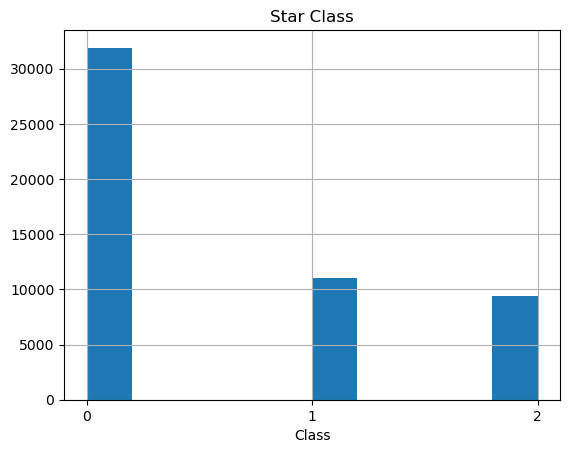

In [9]:
# Disrtibution des classes

df_train['label'].hist()
plt.title('Star Class')
plt.xlabel('Class')
plt.xticks([0,1,2])

Text(0.5, 1.0, 'Correlation Matrix')

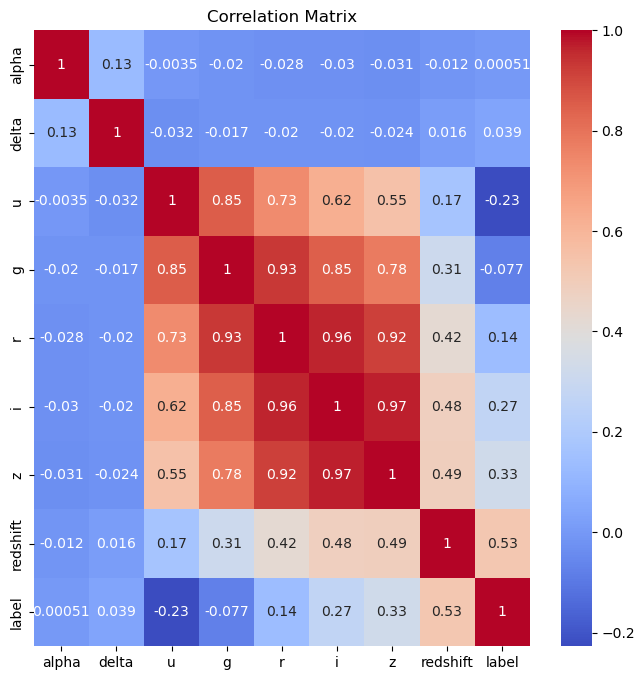

In [10]:
# Matrice de corrélation

plt.figure(figsize=(8, 8))
sns.heatmap(df_train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

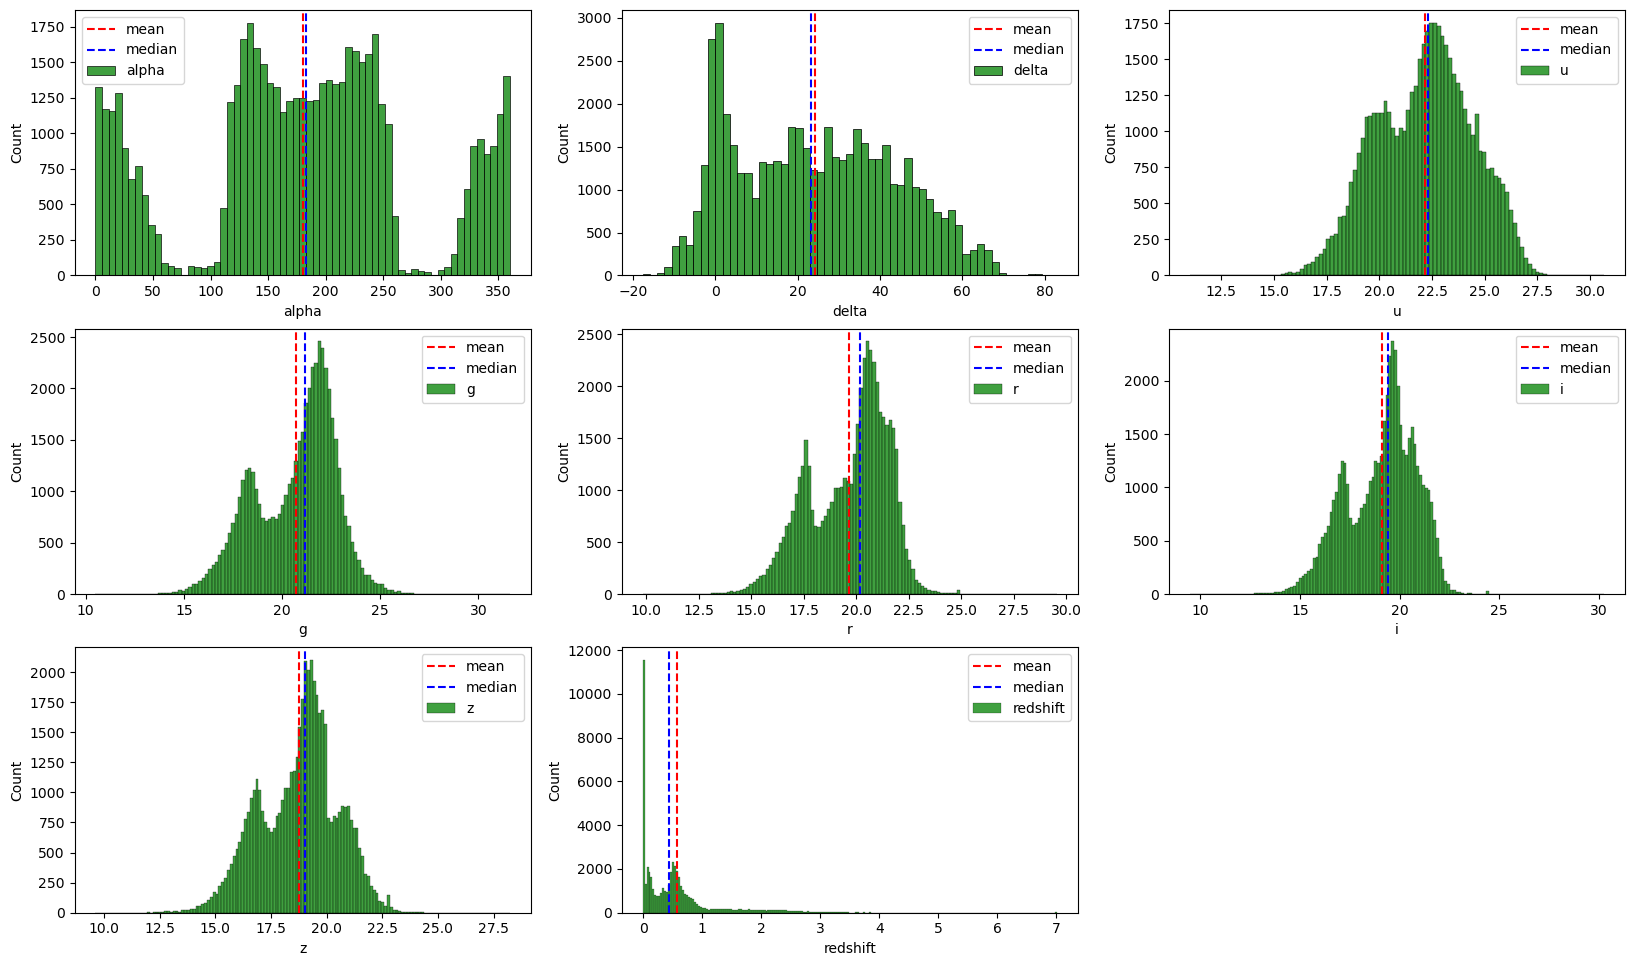

In [11]:
# Distribution des variables

fig = plt.figure(figsize=(20, 20))
for i in range(len(df_train.columns)-1):
    fig.add_subplot(5, 3, i+1)
    sns.histplot(df_train.iloc[:, i], color='green', label=df_train.columns[i])
    # show the mean and median
    plt.axvline(df_train.iloc[:, i].mean(), linestyle='dashed', color='red', label='mean')
    plt.axvline(df_train.iloc[:, i].median(), linestyle='dashed', color='blue', label='median')
    plt.legend()

## Séparation train-test

In [12]:
# Séparation des données en train test

X = df_train.drop('label', axis=1)
y = df_train['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Random Forest Classifier

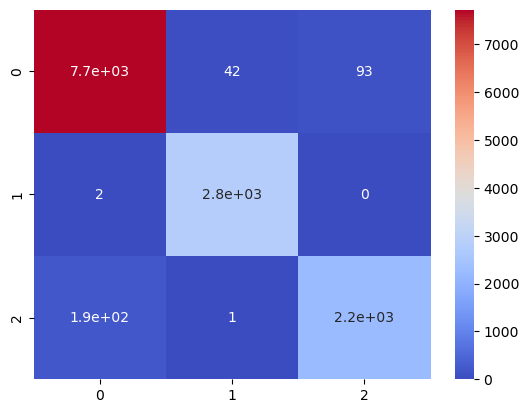

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

best_params = {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

if best_params is None:

    # Définition de notre espaces de paramètres

    params = {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5]
    }

    # Recherche des meilleurs paramètres
    grid = GridSearchCV(rf, params, cv=5, n_jobs=-1, verbose=1)

    grid.fit(X_train, y_train)

    print(f"paramètres optimaux : {grid.best_params_}")

    print(f"meilleur score : {grid.best_score_}")

    best_params = grid.best_params_

rf.set_params(**best_params)

rf.fit(X_train, y_train)

# Prédiction sur les données de test

y_preds = rf.predict(X_test)

# Matrice de confusion

sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, cmap='coolwarm')

# Sauvegarde des résultats pour streamlit

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

# new_results.to_csv('../résultats_models/classif/random_forest.csv', index=False)

# soumission des résultats

rf = RandomForestClassifier(**best_params)

rf.fit(df_train.drop('label', axis=1), df_train['label'])

y_preds = rf.predict(df_test.drop('obj_ID', axis=1))

submission = pd.DataFrame({'obj_ID': df_test['obj_ID'],
                            'label': y_preds})

# submission.to_csv('../soumission/classif/random_forest.csv', index=False)

## CatBoost Classifier

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7862
           1       0.99      1.00      0.99      2812
           2       0.96      0.93      0.94      2400

    accuracy                           0.98     13074
   macro avg       0.98      0.97      0.97     13074
weighted avg       0.98      0.98      0.98     13074



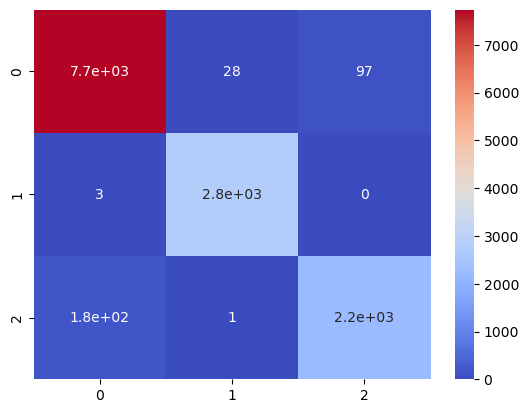

In [14]:
from catboost import CatBoostClassifier

# Définition de notre modèle

if train_model:

    cat = CatBoostClassifier(n_estimators=3000, max_depth=10, learning_rate=0.01)

    # Entrainement du modèle

    cat.fit(X_train, y_train, verbose=1)

    pickle.dump(cat, open('../models/classification/catboost.pkl', 'wb'))

else:

    cat = pickle.load(open('../models/classification/catboost.pkl', 'rb'))

# Prédiction sur les données de test

y_preds = cat.predict(X_test)

# Matrice de confusion

sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, cmap='coolwarm')

print(classification_report(y_test, y_preds))

# Sauvegarde des résultats pour streamlit

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds.ravel()})

# new_results.to_csv('../résultats_models/classif/catboost.csv', index=False)

# soumission des résultats

if train_model:

    cat = CatBoostClassifier(n_estimators=3000, max_depth=10, learning_rate=0.01)

    cat.fit(df_train.drop('label', axis=1), df_train['label'], verbose=1)

    pickle.dump(cat, open('../models/classification/catboost_complet.pkl', 'wb'))

else:

    cat = pickle.load(open('../models/classification/catboost_complet.pkl', 'rb'))

y_preds = cat.predict(df_test.drop('obj_ID', axis=1))

submission = pd.DataFrame({'obj_ID': df_test['obj_ID'],
                            'label': y_preds.ravel()})

# submission.to_csv('../soumission/classif/catboost.csv', index=False)


## Neural Network

In [15]:
trainset = TensorDataset(torch.from_numpy(X_train.values).float(), torch.from_numpy(y_train.values).long())
testset = TensorDataset(torch.from_numpy(X_test.values).float(), torch.from_numpy(y_test.values).long())

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

fullset = TensorDataset(torch.from_numpy(df_train.drop('label', axis=1).values).float(), torch.from_numpy(df_train['label'].values).long())
fullset_loder = DataLoader(fullset, batch_size=32, shuffle=True)
full_testset = TensorDataset(torch.from_numpy(df_test.drop('obj_ID', axis=1).values).float())

In [16]:
class NeuralNetClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7862
           1       0.92      1.00      0.96      2812
           2       0.94      0.83      0.88      2400

    accuracy                           0.94     13074
   macro avg       0.94      0.93      0.93     13074
weighted avg       0.94      0.94      0.94     13074



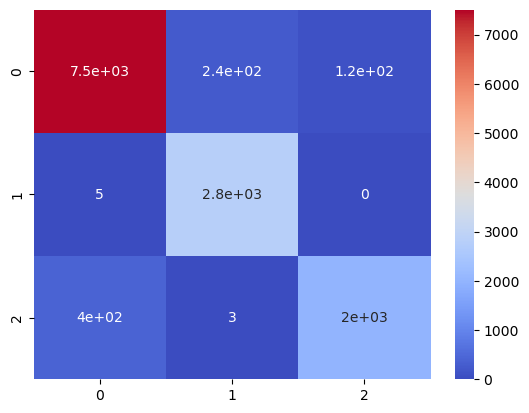

In [17]:
if train_model:

    model = NeuralNetClassifier(input_size=8, hidden_size=5, num_classes=3)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

    for epoch in range(15):
        for i, (inputs, labels) in enumerate(trainloader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            n_correct = 0
            n_samples = 0
            for inputs, labels in testloader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                n_samples += labels.size(0)
                n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples
            print(f'epoch {epoch+1}/{15}, loss={loss.item():.4f} accuracy = {acc}')

    # Prédiction sur les données de test
    y_preds = []
    with torch.no_grad():
        for inputs in testset:
            outputs = model(inputs[0])
            _, predicted = torch.max(outputs.data, 0)
            y_preds.append(predicted.item())

    new_results = pd.DataFrame({'y_test': y_test,
                                'y_preds': y_preds})

    pickle.dump(model, open('../models/classification/neural_net.pkl', 'wb'))

else:

    model = pickle.load(open('../models/classification/neural_net.pkl', 'rb'))

    y_preds = []
    with torch.no_grad():
        for inputs in testset:
            outputs = model(inputs[0])
            _, predicted = torch.max(outputs.data, 0)
            y_preds.append(predicted.item())

    new_results = pd.DataFrame({'y_test': y_test,
                                'y_preds': y_preds})
    
sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, cmap='coolwarm')

print(classification_report(y_test, y_preds))

# new_results.to_csv('../résultats_models/classif/neural_net.csv', index=False)



In [18]:
if train_model:

    model = NeuralNetClassifier(input_size=8, hidden_size=5, num_classes=3)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

    model = NeuralNetClassifier(input_size=8, hidden_size=5, num_classes=3)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

    for epoch in range(30):
        for i, (inputs, labels) in enumerate(fullset_loder):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            n_correct = 0
            n_samples = 0
            for inputs, labels in testloader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                n_samples += labels.size(0)
                n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples
            print(f'epoch {epoch+1}/{30}, loss={loss.item():.4f} accuracy = {acc}')

    with torch.no_grad():
        y_preds = []
        for inputs in full_testset:
            outputs = model(inputs[0])
            _, predicted = torch.max(outputs.data, 0)
            y_preds.append(predicted.item())

    pickle.dump(model, open('../models/classification/neural_net_complet.pkl', 'wb'))

else:
    
        model = pickle.load(open('../models/classification/neural_net_complet.pkl', 'rb'))
    
        with torch.no_grad():
            y_preds = []
            for inputs in full_testset:
                outputs = model(inputs[0])
                _, predicted = torch.max(outputs.data, 0)
                y_preds.append(predicted.item())

submission = pd.DataFrame({'obj_ID': df_test['obj_ID'],
                            'label': y_preds})

# submission.to_csv('../soumission/classif/neural_net.csv', index=False)

# SVM

In [43]:
from sklearn.svm import SVC

svc = SVC()

best_params = {'kernel':'poly', 'C':1000}

if best_params is None:
    params = {'kernel': ['poly'],
              'C': [10, 100, 1000],
          }

    grid = GridSearchCV(svc, params, refit=True, verbose=3, n_jobs=-1)

    grid.fit(X_train, y_train)

    print(grid.best_params_)
    print(grid.best_estimator_)
    print(grid.best_score_)
    best_params = grid.best_params_

svc.set_params(**best_params)

svc.fit(X_train, y_train)

y_preds = svc.predict(X_test)

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

# new_results.to_csv('../résultats_models/classif/svc.csv', index=False)

y_preds = svc.predict(df_test.drop('obj_ID', axis=1))

submission = pd.DataFrame({'obj_ID': df_test['obj_ID'],
                            'label': y_preds})

# submission.to_csv('../soumission/classif/svc.csv', index=False)

## Normalisation des données

In [19]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_train_scaled = scaler.fit_transform(df_train.drop('label', axis=1))
df_test_scaled = scaler.transform(df_test.drop('obj_ID', axis=1))

## Random Forest Classifier

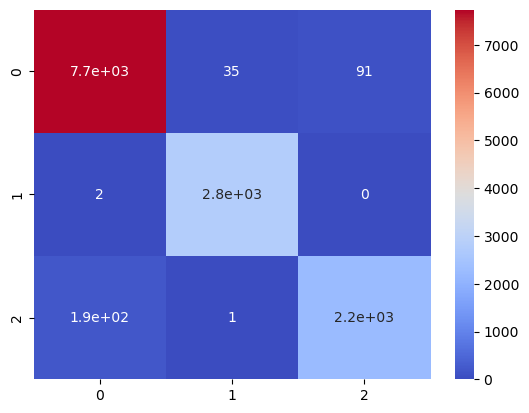

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

best_params = {'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

if best_params is None:

    # Définition de notre espaces de paramètres

    params = {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5]
    }

    # Recherche des meilleurs paramètres
    grid = GridSearchCV(rf, params, cv=5, n_jobs=-1, verbose=1)

    grid.fit(X_train_scaled, y_train)

    print(f"paramètres optimaux : {grid.best_params_}")

    print(f"meilleur score : {grid.best_score_}")
    best_params = grid.best_params_

rf.set_params(**best_params)

rf.fit(X_train_scaled, y_train)

# Prédiction sur les données de test

y_preds = rf.predict(X_test_scaled)

# Matrice de confusion

sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, cmap='coolwarm')

# Sauvegarde des résultats pour streamlit

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

# new_results.to_csv('../résultats_models/classif/random_forest_scaled.csv', index=False)

# soumission des résultats

rf = RandomForestClassifier(**grid.best_params_)

rf.fit(df_train_scaled, df_train['label'])

y_preds = rf.predict(df_test_scaled)

submission = pd.DataFrame({'obj_ID': df_test['obj_ID'],
                            'label': y_preds})

# submission.to_csv('../soumission/classif/random_forest_scaled.csv', index=False)

# CatBoost Classifier

0.9765182805568303


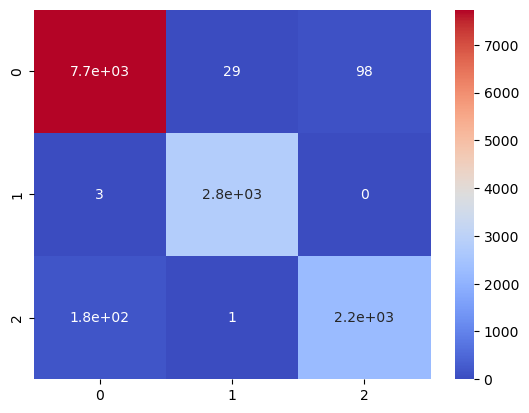

In [21]:
from catboost import CatBoostClassifier

# Définition de notre modèle

if train_model:

    cat = CatBoostClassifier(n_estimators=3000, max_depth=10, learning_rate=0.01)

    # Entrainement du modèle

    cat.fit(X_train_scaled, y_train, verbose=0)

    pickle.dump(cat, open('../models/classification/catboost_scaled.pkl', 'wb'))

else:

    cat = pickle.load(open('../models/classification/catboost_scaled.pkl', 'rb'))

# Prédiction sur les données de test

y_preds = cat.predict(X_test_scaled)

# Matrice de confusion

sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, cmap='coolwarm')

# Sauvegarde des résultats pour streamlit

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds.ravel()})

print(np.sum(y_test == y_preds.ravel()) / len(y_test))

# new_results.to_csv('../résultats_models/classif/catboost_scaled.csv', index=False)

# soumission des résultats

if train_model:

    cat = CatBoostClassifier(n_estimators=3000, max_depth=10, learning_rate=0.01)

    cat.fit(df_train_scaled, df_train['label'], verbose=0)

    pickle.dump(cat, open('../models/classification/catboost_scaled_complet.pkl', 'wb'))

else:

    cat = pickle.load(open('../models/classification/catboost_scaled_complet.pkl', 'rb'))

y_preds = cat.predict(df_test_scaled)

submission = pd.DataFrame({'obj_ID': df_test['obj_ID'],
                            'label': y_preds.ravel()})

# submission.to_csv('../soumission/classif/catboost_scaled.csv', index=False)


## Neural Network

In [23]:
trainset = TensorDataset(torch.from_numpy(X_train_scaled).float(), torch.from_numpy(y_train.values).long())
testset = TensorDataset(torch.from_numpy(X_test_scaled).float(), torch.from_numpy(y_test.values).long())

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

fullset = TensorDataset(torch.from_numpy(df_train_scaled).float(), torch.from_numpy(df_train['label'].values).long())
fullset_loder = DataLoader(fullset, batch_size=32, shuffle=True)
full_testset = TensorDataset(torch.from_numpy(df_test_scaled).float())

In [24]:
class NeuralNetClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    

model = NeuralNetClassifier(input_size=8, hidden_size=5, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      7862
           1       0.95      1.00      0.98      2812
           2       0.96      0.88      0.92      2400

    accuracy                           0.96     13074
   macro avg       0.96      0.95      0.95     13074
weighted avg       0.96      0.96      0.96     13074



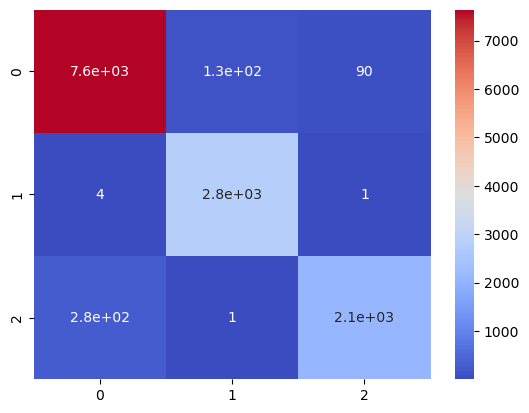

In [29]:
if train_model:

    for epoch in range(50):
        for i, (inputs, labels) in enumerate(trainloader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            n_correct = 0
            n_samples = 0
            for inputs, labels in testloader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                n_samples += labels.size(0)
                n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples
            print(f'epoch {epoch+1}/{50}, loss={loss.item():.4f} accuracy = {acc}')

    # Prédiction sur les données de test
    y_preds = []
    with torch.no_grad():
        for inputs in testset:
            outputs = model(inputs[0])
            _, predicted = torch.max(outputs.data, 0)
            y_preds.append(predicted.item())

    pickle.dump(model, open('../models/classification/neural_net_scaled.pkl', 'wb'))

else:

    model = pickle.load(open('../models/classification/neural_net_scaled.pkl', 'rb'))

    y_preds = []
    with torch.no_grad():
        for inputs in testset:
            outputs = model(inputs[0])
            _, predicted = torch.max(outputs.data, 0)
            y_preds.append(predicted.item())

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

print(classification_report(y_test, y_preds))

sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, cmap='coolwarm')



new_results.to_csv('../résultats_models/classif/neural_net_scaled.csv', index=False)



In [31]:
if train_model:

    model = NeuralNetClassifier(input_size=8, hidden_size=5, num_classes=3)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

    model = NeuralNetClassifier(input_size=8, hidden_size=5, num_classes=3)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

    for epoch in range(50):
        for i, (inputs, labels) in enumerate(fullset_loder):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            n_correct = 0
            n_samples = 0
            for inputs, labels in testloader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                n_samples += labels.size(0)
                n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples
            print(f'epoch {epoch+1}/{50}, loss={loss.item():.4f} accuracy = {acc}')

    with torch.no_grad():
        y_preds = []
        for inputs in full_testset:
            outputs = model(inputs[0])
            _, predicted = torch.max(outputs.data, 0)
            y_preds.append(predicted.item())

    pickle.dump(model, open('../models/classification/neural_net_scaled_complet.pkl', 'wb'))

else:

    model = pickle.load(open('../models/classification/neural_net_scaled_complet.pkl', 'rb'))

    with torch.no_grad():
        y_preds = []
        for inputs in full_testset:
            outputs = model(inputs[0])
            _, predicted = torch.max(outputs.data, 0)
            y_preds.append(predicted.item())

submission = pd.DataFrame({'obj_ID': df_test['obj_ID'],
                            'label': y_preds})

submission.to_csv('../soumission/classif/neural_net_scaled.csv', index=False)

# SVC

In [29]:
from sklearn.svm import SVC

svc = SVC()


from sklearn.svm import SVC

svc = SVC()

best_params = {'C': 1000, 'kernel': 'poly'}

if best_params is None:
    params = {'kernel': ['poly'],
              'C': [1, 10, 100, 1000],
          }

    grid = GridSearchCV(svc, params, refit=True, verbose=3, n_jobs=-1)

    grid.fit(X_train_scaled, y_train)

    print(grid.best_params_)
    print(grid.best_estimator_)
    print(grid.best_score_)
    best_params = grid.best_params_

svc.set_params(**best_params)

svc.fit(X_train_scaled, y_train)

y_preds = svc.predict(X_test_scaled)

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

new_results.to_csv('../résultats_models/classif/svc_scaled.csv', index=False)

y_preds = svc.predict(df_test_scaled)

submission = pd.DataFrame({'obj_ID': df_test['obj_ID'],
                            'label': y_preds})

submission.to_csv('../soumission/classif/svc_scaled.csv', index=False)